In [ ]:
# This notebook contains some experiments and obsolete code.
# It is superseded by rps_train.ipynb and rps_quantize_and_test.ipynb

In [7]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import seaborn as sb

import random

tf.enable_eager_execution()

In [4]:
raw_data = []
with open("Rock_Paper_Scissors_Raw.csv", encoding="utf-8") as f:
    f.readline() # header
    for line in f:
        raw_data.append([int(c) for c in line.split(",")])

In [5]:
game_data = []
current_game_id = None
current_game = []

for r in raw_data:
    if r[2] == 0 or r[3] ==0:
        continue
    if current_game_id != r[0]:
        game_data.append(current_game)
        current_game_id = r[0]
        current_game = []
    current_game.append((r[2], r[3]))

game_data = game_data[1:]

In [12]:
len(game_data)

85566

In [5]:
from collections import Counter

Counter([g[0][0] for g in game_data if len(g) > 3])

Counter({1: 21197, 3: 15479, 2: 19738})

In [23]:
game_data_simulated = []
r_move = lambda : random.choice((1,2,3))

# length=1 (constant)
game_data_simulated += [[(move, r_move()) for i in range(20)] for move in (1,2,3) for i_g in range(500)]

# length=2 (alternating)
game_data_simulated += [sum(([(move1, r_move()), (move2, r_move())] for i in range(10)), [])
                        for move1 in (1,2,3) for move2 in (1,2,3) for i_g in range(200)]

# length=3 
game_data_simulated += [sum(([(move1, r_move()), (move2, r_move()), (move3, r_move())] for i in range(7)), [])
                        for move1 in (1,2,3) for move2 in (1,2,3) for move3 in (1,2,3) for i_g in range(150)]

# length=4
game_data_simulated += [sum(([(move1, r_move()), (move2, r_move()), (move3, r_move()), (move4, r_move())]
                             for i in range(5)), [])
                        for move1 in (1,2,3) for move2 in (1,2,3) for move3 in (1,2,3) for move4 in (1,2,3) 
                        for i_g in range(50)]


In [24]:
len(game_data_simulated)

11400

In [26]:
def enc_game(game, invert=False):
    game_enc = []
    # we add a zero input to the beginning
    # as the model should be able to predict the first move
    game_enc.append([0] * 6)
    for p1, p2 in game:
        if invert:
            p1, p2 = p2, p1
        game_enc.append([0] * 6)
        game_enc[-1][p1 - 1] = 1
        game_enc[-1][p2 - 1 + 3] = 1
    return game_enc

In [27]:
game_data_one_hot = []
for game in game_data:
    # for real games we can use both players to train
    for invert in (True, False):
        game_data_one_hot.append(enc_game(game, invert=invert))
for game in game_data_simulated:
    # for simulated games we don't train on the player playing randomly
    game_data_one_hot.append(enc_game(game))

In [101]:
# masking seems to do something, but the models trained with it behave very weirdly...
# after a few moves they believe with 99.99999% probability that some move will be played
# and get stuck at that ludicrous confidence

game_data_padded = tf.keras.preprocessing.sequence.pad_sequences(game_data_one_hot, maxlen=21, value=-1.0,
                                                                 truncating="post", padding="post"
                                                                ).astype("float32")

In [102]:
game_data_padded.shape

(171132, 21, 6)

In [103]:
X = game_data_padded[:, :20, :]
# The first three components in axis=-1 are the opponents throw
Y = game_data_padded[:, 1:, :3]

In [105]:
X[0]

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  1.,  0.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1.]], dtype=float32)

In [106]:
Y[0]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.],
       [-1., -1., -1.]], dtype=float32)

In [58]:
# adding sample weights doesn't seem to work correctly

# although if I set all weights to zero that seems to have the expected effect

sample_weights_temporal = np.zeros(Y.shape[:-1]).astype(np.float32)

for i,g in enumerate(game_data):
    sample_weights_temporal[i, :len(g)] = 1

In [32]:
sample_weights_temporal.shape

(171132, 20)

In [154]:
# for batchsize=1 training
# training with batchsize 1 is very slow but the resulting models at least make sense

X = [game[:-1] for game in game_data_one_hot]
Y = [[move[:3] for move in game[1:]] for game in game_data_one_hot]
X_np = [np.array(x).astype(np.float32) for x in X]
Y_np = [np.array(y).astype(np.float32) for y in Y]
dataset = tf.data.Dataset.from_generator(lambda: zip(X_np, Y_np), output_types=(tf.dtypes.float32, tf.dtypes.float32))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [107]:
#dataset = tf.data.Dataset.from_tensor_slices((X, Y))

In [155]:
test_size = 2000
dev_size = 2000
dataset = dataset.shuffle(10000)
test_dataset = dataset.take(test_size)
dev_dataset = dataset.skip(test_size).take(dev_size)
train_dataset = dataset.skip(test_size + dev_size)
train_size = len(X) - test_size - dev_size

In [120]:
#print(X.shape, Y.shape)

AttributeError: 'list' object has no attribute 'shape'

In [66]:
len([1 for g in game_data if 20 >= len(g) >= 3])

65697

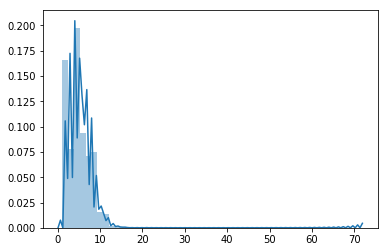

In [67]:
sb.distplot(list(map(len, game_data)))

In [2]:
def build_simple_model(state_dim, batch_size, stateful=False):
    return tf.keras.Sequential([
        #tf.keras.layers.Masking(mask_value=-1.0, batch_input_shape=[batch_size, None, 6]),
        tf.keras.layers.SimpleRNN(state_dim, batch_input_shape=[batch_size, None, 6],
                                 return_sequences=True,  stateful=stateful),
        tf.keras.layers.Dense(3),
        tf.keras.layers.Softmax()
    ])

In [159]:
def build_simple_2_layer_model(state1_dim, state2_dim,  batch_size, stateful=False):
    return tf.keras.Sequential([
        #tf.keras.layers.Masking(mask_value=-1.0, batch_input_shape=[batch_size, None, 6]),
        tf.keras.layers.SimpleRNN(state1_dim, batch_input_shape=[batch_size, None, 6],
                                 return_sequences=True,  stateful=stateful),
        tf.keras.layers.SimpleRNN(state2_dim, return_sequences=True, stateful=stateful),
        tf.keras.layers.Dense(3),
        tf.keras.layers.Softmax()
    ])

In [162]:
batch_size = 1
train_dataset_batched = train_dataset.batch(batch_size, drop_remainder=True).repeat()
simple_2l_model = build_simple_2_layer_model(10, 6, batch_size)
opt = tf.keras.optimizers.Adam(lr=0.001)
simple_2l_model.compile(opt, loss=tf.keras.losses.categorical_crossentropy,metrics = ["accuracy"])

In [165]:
tf.keras.backend.set_value(simple_model.optimizer.lr, 0.01)

In [167]:
simple_2l_model.fit(train_dataset_batched, steps_per_epoch=train_size // batch_size, epochs=10)

Epoch 1/10
167132/167132 [==============================] - 1169s 7ms/step - loss: 1.0909 - acc: 0.3813
Epoch 2/10
167132/167132 [==============================] - 1161s 7ms/step - loss: 1.0906 - acc: 0.3823
Epoch 3/10
167132/167132 [==============================] - 1154s 7ms/step - loss: 1.0906 - acc: 0.3828
Epoch 4/10
167132/167132 [==============================] - 1155s 7ms/step - loss: 1.0905 - acc: 0.3824
Epoch 5/10
167132/167132 [==============================] - 1151s 7ms/step - loss: 1.0903 - acc: 0.3835
Epoch 6/10
167132/167132 [==============================] - 1151s 7ms/step - loss: 1.0903 - acc: 0.3838
Epoch 7/10
167132/167132 [==============================] - 1147s 7ms/step - loss: 1.0901 - acc: 0.3842
Epoch 8/10
167132/167132 [==============================] - 1152s 7ms/step - loss: 1.0901 - acc: 0.3843
Epoch 9/10
167132/167132 [==============================] - 1157s 7ms/step - loss: 1.0902 - acc: 0.3847
Epoch 10/10
167132/167132 [==============================] - 115

In [168]:
simple_2l_model.fit(train_dataset_batched, steps_per_epoch=train_size // batch_size, epochs=10)

Epoch 1/10
167132/167132 [==============================] - 1150s 7ms/step - loss: 1.0901 - acc: 0.3844
Epoch 2/10
167132/167132 [==============================] - 1150s 7ms/step - loss: 1.0901 - acc: 0.3843
Epoch 3/10
167132/167132 [==============================] - 1149s 7ms/step - loss: 1.0900 - acc: 0.3845
Epoch 4/10
167132/167132 [==============================] - 1152s 7ms/step - loss: 1.0901 - acc: 0.3844
Epoch 5/10
167132/167132 [==============================] - 1147s 7ms/step - loss: 1.0900 - acc: 0.3846
Epoch 6/10
167132/167132 [==============================] - 1151s 7ms/step - loss: 1.0899 - acc: 0.3846
Epoch 7/10
167132/167132 [==============================] - 1149s 7ms/step - loss: 1.0900 - acc: 0.3844
Epoch 8/10
167132/167132 [==============================] - 1149s 7ms/step - loss: 1.0900 - acc: 0.3848
Epoch 9/10
167132/167132 [==============================] - 1153s 7ms/step - loss: 1.0900 - acc: 0.3844
Epoch 10/10
167132/167132 [==============================] - 115

In [169]:
tf.keras.backend.set_value(simple_model.optimizer.lr, 0.001)

In [170]:
simple_2l_model.fit(train_dataset_batched, steps_per_epoch=train_size // batch_size, epochs=10)

Epoch 1/10
167132/167132 [==============================] - 1150s 7ms/step - loss: 1.0899 - acc: 0.3849
Epoch 2/10
167132/167132 [==============================] - 1148s 7ms/step - loss: 1.0901 - acc: 0.3849
Epoch 3/10
167132/167132 [==============================] - 1148s 7ms/step - loss: 1.0900 - acc: 0.3848
Epoch 4/10
167132/167132 [==============================] - 1146s 7ms/step - loss: 1.0900 - acc: 0.3848
Epoch 5/10
167132/167132 [==============================] - 1147s 7ms/step - loss: 1.0899 - acc: 0.3845
Epoch 6/10
167132/167132 [==============================] - 1144s 7ms/step - loss: 1.0900 - acc: 0.3844
Epoch 7/10
167132/167132 [==============================] - 1145s 7ms/step - loss: 1.0899 - acc: 0.3854
Epoch 8/10
167132/167132 [==============================] - 1150s 7ms/step - loss: 1.0900 - acc: 0.3850
Epoch 9/10
167132/167132 [==============================] - 1151s 7ms/step - loss: 1.0900 - acc: 0.3852
Epoch 10/10
167132/167132 [==============================] - 115

In [171]:
simple_2l_model.fit(train_dataset_batched, steps_per_epoch=train_size // batch_size, epochs=10)

Epoch 1/10
167132/167132 [==============================] - 1145s 7ms/step - loss: 1.0899 - acc: 0.3849
Epoch 2/10
167132/167132 [==============================] - 1147s 7ms/step - loss: 1.0900 - acc: 0.3845
Epoch 3/10
167132/167132 [==============================] - 1154s 7ms/step - loss: 1.0899 - acc: 0.3845
Epoch 4/10
167132/167132 [==============================] - 1154s 7ms/step - loss: 1.0899 - acc: 0.3847
Epoch 5/10
167132/167132 [==============================] - 1155s 7ms/step - loss: 1.0899 - acc: 0.3849
Epoch 6/10
167132/167132 [==============================] - 1156s 7ms/step - loss: 1.0899 - acc: 0.3847
Epoch 7/10
167132/167132 [==============================] - 1153s 7ms/step - loss: 1.0900 - acc: 0.3846
Epoch 8/10
167132/167132 [==============================] - 1151s 7ms/step - loss: 1.0899 - acc: 0.3853
Epoch 9/10
167132/167132 [==============================] - 1153s 7ms/step - loss: 1.0899 - acc: 0.3853
Epoch 10/10
167132/167132 [==============================] - 114

In [212]:
tf.keras.backend.set_value(simple_2l_model.optimizer.lr, 0.00001)
simple_2l_model.fit(train_dataset_batched, steps_per_epoch=train_size // batch_size, epochs=20)

Epoch 1/20
167132/167132 [==============================] - 1164s 7ms/step - loss: 1.0888 - acc: 0.3872
Epoch 2/20
167132/167132 [==============================] - 1157s 7ms/step - loss: 1.0886 - acc: 0.3878
Epoch 3/20
167132/167132 [==============================] - 1153s 7ms/step - loss: 1.0886 - acc: 0.3879
Epoch 4/20
167132/167132 [==============================] - 1159s 7ms/step - loss: 1.0885 - acc: 0.3879
Epoch 5/20
167132/167132 [==============================] - 1160s 7ms/step - loss: 1.0885 - acc: 0.3882
Epoch 6/20
167132/167132 [==============================] - 1156s 7ms/step - loss: 1.0885 - acc: 0.3879
Epoch 7/20
167132/167132 [==============================] - 1157s 7ms/step - loss: 1.0885 - acc: 0.3879
Epoch 8/20
 90917/167132 [===============>..............] - ETA: 8:50 - loss: 1.0898 - acc: 0.383

KeyboardInterrupt: 

In [174]:
simple_2l_model.evaluate(dev_dataset.batch(batch_size), steps=dev_size//batch_size)

2000/2000 [==============================] - 8s 4ms/step - loss: 1.0927 - acc: 0.3844


[1.0927284483015538, 0.384404]

In [213]:
simple_2l_model.save("simple_2l_model_b1_acc38_full.hdf5")
simple_2l_model.save_weights("simple_2l_model_b1_acc38.h5")

RuntimeError: Unable to create link (name already exists)

In [180]:
simple_2l_model_test = build_simple_2_layer_model(10,6, 1, stateful=True)
simple_2l_model_test.load_weights("simple_2l_model_b1_acc38.h5")

In [3]:
def make_input_vector(opponent_move=None, model_move=None):
    if opponent_move is None and model_move is None:
        return np.zeros((1,1,6)).astype(np.float32)
    elif opponent_move is None or model_move is None:
        raise ValueError
    move_ids = {"r": [1,0,0], "p": [0,1,0], "s": [0,0,1]}
    return np.array([[move_ids[opponent_move] + move_ids[model_move]]]).astype(np.float32)

In [208]:
simple_2l_model_test(make_input_vector("p", "r"))

<tf.Tensor: id=110479751, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.42245346, 0.27645314, 0.3010934 ]]], dtype=float32)>

In [211]:
sum(np.prod(w.shape) for w in simple_2l_model_test.get_weights())

293

In [125]:
batch_size = 256
train_dataset_batched = train_dataset.batch(batch_size, drop_remainder=True).repeat()
simple_model = build_simple_model(10, batch_size)
opt = tf.keras.optimizers.Adam(lr=0.001)
simple_model.compile(opt, loss=tf.keras.losses.categorical_crossentropy,metrics = ["accuracy"])

In [37]:
train_dataset_batched.take(1)

<DatasetV1Adapter shapes: ((256, 20, 6), (256, 20, 3), (256, 20)), types: (tf.float32, tf.float32, tf.float32)>

In [145]:
tf.keras.backend.set_value(simple_model.optimizer.lr, 0.0001)

In [146]:
simple_model.fit(train_dataset_batched, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
652/652 [==============================] - 9s 13ms/step - loss: -2.2785 - acc: 0.3112
Epoch 2/5
652/652 [==============================] - 9s 14ms/step - loss: -2.2799 - acc: 0.3130
Epoch 3/5
652/652 [==============================] - 9s 14ms/step - loss: -2.2795 - acc: 0.3144
Epoch 4/5
652/652 [==============================] - 9s 14ms/step - loss: -2.2800 - acc: 0.3152
Epoch 5/5
652/652 [==============================] - 9s 13ms/step - loss: -2.2794 - acc: 0.3152


In [144]:
simple_model.evaluate(dev_dataset.batch(batch_size), steps=dev_size//batch_size)

7/7 [==============================] - 0s 8ms/step - loss: -2.4219 - acc: 0.2967


[-2.421852009637015, 0.296655]

In [147]:
simple_model.save_weights("simple_s10_b256_masking.h5")

In [99]:
ws = simple_model.get_weights()

In [218]:
def quantize_array_8bit(arr):
    max_val = np.max(arr)
    min_val = np.min(arr)
    scale_factor = (max_val - min_val) / 255
    normalized_arr = (arr - min_val) / scale_factor
    uint8_arr = normalized_arr.astype(np.uint8)
    quantized_float_arr = uint8_arr.astype(np.float32) * scale_factor + min_val
    return uint8_arr, min_val, scale_factor, quantized_float_arr

In [219]:
quantize_array_8bit(np.array([[0.1, 100.5, 23.0], [0.0,0.0,0.0], [-10.3, 5.36, 72.891]]))

(array([[ 23, 255,  76],
        [ 23,  23,  23],
        [  0,  36, 191]], dtype=uint8),
 -10.3,
 0.4345098039215686,
 array([[ -0.3062744, 100.5      ,  22.722748 ],
        [ -0.3062744,  -0.3062744,  -0.3062744],
        [-10.3      ,   5.342353 ,  72.69137  ]], dtype=float32))

In [245]:
quantize_array_8bit(np.array([[0.1, 100.5, 23.0], [0.0,0.0,0.0], [-10.3, 5.36, 72.891]]))

(array([[ 23, 255,  76],
        [ 23,  23,  23],
        [  0,  36, 191]], dtype=uint8),
 array([[ -0.3062744, 100.5      ,  22.722748 ],
        [ -0.3062744,  -0.3062744,  -0.3062744],
        [-10.3      ,   5.342354 ,  72.691376 ]], dtype=float32))

In [100]:
ws[0]

array([[-2.0455706 ,  1.0283102 , -0.9659117 ,  3.548289  , -1.1276885 ,
        -1.138939  ,  2.5859563 , -0.7097592 , -0.92650974,  1.8484266 ],
       [-5.0574603 ,  1.2583566 , -1.226542  ,  0.21674812, -3.252657  ,
         1.1813297 , -3.2153454 , -0.57423186, -2.340138  ,  3.0763323 ],
       [ 1.7969029 ,  2.8700786 ,  1.084077  ,  1.1550727 , -1.7931525 ,
         3.855419  , -2.0228846 ,  0.6389722 , -2.2819788 ,  3.4723608 ],
       [-7.084231  ,  2.6387463 , -1.3700198 ,  1.1301912 , -2.0216262 ,
         1.9781357 ,  1.409669  ,  0.638562  , -4.234835  ,  2.4809246 ],
       [ 2.5644126 ,  0.63514644,  0.72990674,  2.0799232 , -2.2121131 ,
         2.115727  , -1.339455  ,  0.17723703, -0.81895775,  2.3882298 ],
       [-1.7927575 , -0.06489968, -0.8500483 ,  1.489895  , -1.5608385 ,
        -0.7815637 , -3.2034628 , -1.910331  , -3.7538776 ,  3.7661796 ]],
      dtype=float32)

In [247]:
quantize_array_8bit(ws[0])

(array([[237, 157,  67, 155, 226,  52, 185,  92, 196,  88],
        [130, 219, 200, 170, 110,   6, 118, 221, 255, 193],
        [ 85,  79, 137, 170, 192, 201, 158, 156,  76, 189],
        [140, 130, 156, 155, 184, 142, 175, 197, 196, 149],
        [168, 137, 159, 137, 134, 178, 211, 169, 129, 136],
        [187, 136, 131, 154, 143,   0, 162,  86, 147, 160]], dtype=uint8),
 array([[ 1.1916376 ,  0.1680547 , -0.98347616,  0.14246511,  1.0508949 ,
         -1.1753981 ,  0.52630866, -0.6636065 ,  0.66705143, -0.7147857 ],
        [-0.17740452,  0.9613315 ,  0.7182306 ,  0.33438694, -0.43330038,
         -1.7639582 , -0.33094203,  0.98692095,  1.4219438 ,  0.628667  ],
        [-0.75317   , -0.82993877, -0.08784103,  0.33438694,  0.61587226,
          0.73102534,  0.18084943,  0.15525997, -0.8683231 ,  0.5774878 ],
        [-0.04945672, -0.17740452,  0.15525997,  0.14246511,  0.5135139 ,
         -0.02386713,  0.39836085,  0.67984617,  0.66705143,  0.06569636],
        [ 0.30879724, -0.0878

In [249]:
quantized_ws = [quantize_array_8bit(w)[1] for w in ws]

In [250]:
simple_model.set_weights(quantized_ws)

In [252]:
simple_model.evaluate(dev_dataset.batch(batch_size), steps=dev_size//batch_size)

2000/2000 [==============================] - 6s 3ms/step - loss: 1.0929 - acc: 0.3692


[1.0929317570328712, 0.3692203]

In [253]:
#simple_model.save_weights("simple_s10_b1_acc37_quantized.h5")

In [4]:
simple_model_test = build_simple_model(10, 1, stateful=True)
simple_model_test.load_weights("simple_s10_b1_acc38.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
ws = simple_model_test.get_weights()

In [226]:
quantized_ws = [quantize_array_8bit(w) for w in ws]

In [230]:
ws[-1]

array([-0.02720571, -0.03758323, -0.16626628], dtype=float32)

In [227]:
[w.shape for w in ws]

[(6, 10), (10, 10), (10,), (10, 3), (3,)]

In [229]:
[(q[0].shape, q[0].reshape(-1), q[1], q[2]) for q in quantized_ws]

[((6, 10),
  array([237, 157,  67, 155, 226,  52, 185,  92, 196,  88, 130, 219, 200,
         170, 110,   6, 118, 221, 255, 193,  85,  79, 137, 170, 192, 201,
         158, 156,  76, 189, 140, 130, 156, 155, 184, 142, 175, 197, 196,
         149, 168, 137, 159, 137, 134, 178, 211, 169, 129, 136, 187, 136,
         131, 154, 143,   0, 162,  86, 147, 160], dtype=uint8),
  -1.840727,
  0.012794787276024911),
 ((10, 10),
  array([215, 115, 123,  78, 141, 159, 184, 149, 154, 113, 107, 255, 224,
         166,  54, 133, 181, 102,  50,  29, 144,  51, 120, 117, 168,  80,
          28,  61, 140, 182, 103, 132, 206, 225,  50,  82, 186, 109,  82,
          33,  53,  74,  36, 103, 160, 153, 126, 148, 155,  99, 109,  65,
          70, 161,  99, 138, 105, 123, 106,  70,  89,  56,  95,  98, 108,
          98, 112, 134, 176, 141, 138, 112, 161, 159, 117,  65, 125, 121,
          84,  96, 205, 202, 216, 102, 118, 148, 200, 119, 182, 124, 162,
          85, 156, 102,  64,   0,  18,  57,  34, 146], dtype=

In [217]:
ws[0].reshape(-1)

array([ 1.1916376 ,  0.1680547 , -0.98347616,  0.14246511,  1.0508949 ,
       -1.1753981 ,  0.52630866, -0.6636065 ,  0.66705143, -0.7147857 ,
       -0.17740452,  0.9613315 ,  0.7182306 ,  0.33438694, -0.43330038,
       -1.7639582 , -0.33094203,  0.98692095,  1.4219438 ,  0.628667  ,
       -0.75317   , -0.82993877, -0.08784103,  0.33438694,  0.61587226,
        0.73102534,  0.18084943,  0.15525997, -0.8683231 ,  0.5774878 ,
       -0.04945672, -0.17740452,  0.15525997,  0.14246511,  0.5135139 ,
       -0.02386713,  0.39836085,  0.67984617,  0.66705143,  0.06569636,
        0.30879724, -0.08784103,  0.19364417, -0.08784103, -0.12622535,
        0.4367453 ,  0.85897315,  0.3215922 , -0.19019938, -0.10063577,
        0.55189836, -0.10063577, -0.16460979,  0.12967038, -0.01107228,
       -1.840727  ,  0.2320286 , -0.7403753 ,  0.04010689,  0.20643914],
      dtype=float32)

In [150]:
simple_model_test.reset_states()
simple_model_test(make_input_vector())

<tf.Tensor: id=760446, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.3685719 , 0.34509036, 0.28633767]]], dtype=float32)>

In [153]:
simple_model_test(make_input_vector("r", "p"))

<tf.Tensor: id=760749, shape=(1, 1, 3), dtype=float32, numpy=array([[[1.7653186e-14, 1.0000000e+00, 5.6374139e-26]]], dtype=float32)>

In [10]:
def test_model(model):
    moves = ["r", "p", "s"]
    counter_move = {"r": "p", "p": "s", "s": "r"}
    model_wins = player_wins = 0
    model.reset_states()
    prediction = model(make_input_vector())
    while True:
        player_move = input("r/p/s:")
        if player_move not in ("r", "p", "s"):
            break
        model_move = counter_move[moves[np.argmax(prediction)]]
        print(f"player plays {player_move}")
        print(f"model plays {model_move}")
        if model_move == counter_move[player_move]:
            model_wins += 1
            print(f"model wins! (model win / tot win = {100*model_wins / (model_wins + player_wins) if model_wins else 0:.2f}%)")
        elif player_move == counter_move[model_move]:
            player_wins += 1
            print(f"Player wins! (model win / tot win = {100*model_wins / (model_wins + player_wins) if model_wins else 0:.2f}%)")
        else:
            print("It's a draw!")
        
        prediction = model(make_input_vector(player_move, model_move))
test_model(simple_model_test)

r/p/s:r
player plays r
model plays p
model wins! (model win / tot win = 100.00%)
r/p/s:r
player plays r
model plays p
model wins! (model win / tot win = 100.00%)
r/p/s:p
player plays p
model plays p
It's a draw!
r/p/s:p
player plays p
model plays p
It's a draw!
r/p/s:s
player plays s
model plays s
It's a draw!
r/p/s:s
player plays s
model plays r
model wins! (model win / tot win = 100.00%)
r/p/s:r
player plays r
model plays r
It's a draw!
r/p/s:r
player plays r
model plays s
Player wins! (model win / tot win = 75.00%)
r/p/s:p
player plays p
model plays s
model wins! (model win / tot win = 80.00%)
r/p/s:p
player plays p
model plays r
Player wins! (model win / tot win = 66.67%)
r/p/s:s
player plays s
model plays p
Player wins! (model win / tot win = 57.14%)
r/p/s:s
player plays s
model plays p
Player wins! (model win / tot win = 50.00%)
r/p/s:r
player plays r
model plays p
model wins! (model win / tot win = 55.56%)
r/p/s:r
player plays r
model plays p
model wins! (model win / tot win = 6

In [11]:
ws = simple_model_test.get_weights()
print([w.shape for w in ws])
print(f"total params: {sum([np.product(w.shape) for w in ws])}")

[(6, 10), (10, 10), (10,), (10, 3), (3,)]
total params: 203


In [6]:
def numpy_eval_simple_model(x, ws, state):
    h = x@ws[0] + ws[2]
    new_state = np.tanh(h + state@ws[1])
    logits = new_state@ws[3] + ws[4]
    probs = np.exp(logits) / np.sum(np.exp(logits),axis=-1)
    return new_state, probs
    

In [12]:
numpy_eval_simple_model(np.zeros((1,6)), ws, np.zeros(10))

(array([[ 0.26654428, -0.03666964, -0.04910822, -0.01683108,  0.0872402 ,
         -0.26206548, -0.01738435,  0.24364112,  0.32573011,  0.16994075]]),
 array([[0.36667296, 0.33972614, 0.2936009 ]]))

In [28]:
def numpy_eval_simple_model_like_attiny(x, ws, state, temperature=1.0):
    int_state = state@ws[1]
    print("state@ws[1]")
    print(int_state)
    state, int_state = int_state, state
    
    int_state = x@ws[0]
    print("x@ws[0]")
    print(int_state)
    state = state + int_state
    
    state = state + ws[2]
    print("state+ws[2] (state bias)")
    print(state)
    state = np.tanh(state)
    print("tanh(state)")
    print(state)
    output = state@ws[3]
    print("state@ws[3]")
    print(output)
    output = output + ws[4]
    print("output + ws[4]")
    print(output)
    output = output * temperature
    print("output * temperature")
    print(output)
    probs = np.exp(output) / np.sum(np.exp(output),axis=-1)
    return state, probs
    

In [29]:
numpy_eval_simple_model_like_attiny(np.zeros((1,6)), ws, np.zeros((1,10)))

state@ws[1]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
x@ws[0]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
state+ws[2] (state bias)
[[ 0.2731401  -0.03668609 -0.04914776 -0.01683267  0.08746254 -0.26832491
  -0.0173861   0.24864139  0.33804408  0.17160565]]
tanh(state)
[[ 0.26654428 -0.03666964 -0.04910822 -0.01683108  0.0872402  -0.26206548
  -0.01738435  0.24364112  0.32573011  0.16994075]]
state@ws[3]
[[0.13504404 0.06909104 0.05185561]]
output + ws[4]
[[ 0.10783833  0.03150781 -0.11441067]]
output * temperature
[[ 0.10783833  0.03150781 -0.11441067]]


(array([[ 0.26654428, -0.03666964, -0.04910822, -0.01683108,  0.0872402 ,
         -0.26206548, -0.01738435,  0.24364112,  0.32573011,  0.16994075]]),
 array([[0.36667296, 0.33972614, 0.2936009 ]]))

In [17]:
simple_model_test.reset_states()
simple_model_test(make_input_vector())

<tf.Tensor: id=11267, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.3663328 , 0.34006503, 0.2936022 ]]], dtype=float32)>

In [146]:
def build_GRU_model(state_dim, batch_size, stateful=False):
    return tf.keras.Sequential([
        tf.keras.layers.CuDNNGRU(state_dim, batch_input_shape=[batch_size, None, 6],
                                 return_sequences=True,  stateful=stateful),
        tf.keras.layers.Dense(3),
        tf.keras.layers.Softmax()
    ])

In [152]:
batch_size = 1
train_dataset_batched = train_dataset.batch(batch_size, drop_remainder=True).repeat()
gru_model = build_GRU_model(10, batch_size)
opt = tf.keras.optimizers.Adam(lr=0.01)
gru_model.compile(opt, loss=tf.keras.losses.categorical_crossentropy,metrics = ["accuracy"])

In [153]:
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_7 (CuDNNGRU)       (1, None, 10)             540       
_________________________________________________________________
dense_12 (Dense)             (1, None, 3)              33        
_________________________________________________________________
softmax_12 (Softmax)         (1, None, 3)              0         
Total params: 573
Trainable params: 573
Non-trainable params: 0
_________________________________________________________________


In [149]:
for x,y in train_dataset_batched.take(1):
    print(x.shape, y.shape)
    out = gru_model(x)
    print(out.shape)

(1, 5, 6) (1, 5, 3)
(1, 5, 3)


In [150]:
tf.keras.losses.categorical_crossentropy(y, out)

<tf.Tensor: id=764222, shape=(1, 5), dtype=float32, numpy=
array([[1.0986123 , 1.0743761 , 1.0894954 , 0.8406325 , 0.97202396]],
      dtype=float32)>

In [184]:
tf.keras.backend.set_value(gru_model.optimizer.lr, 0.001)

In [185]:
gru_model.fit(train_dataset_batched, steps_per_epoch=train_size // batch_size, epochs=10)

Epoch 1/10
 18331/167132 [==>...........................] - ETA: 12:54 - loss: 1.0976 - acc: 0.3570

KeyboardInterrupt: 

In [90]:
gru_model.evaluate(train_dataset_batched, steps=train_size//batch_size)

2611/2611 [==============================] - 8s 3ms/step - loss: 0.2593 - acc: 0.8536


[0.2592833442724057, 0.8536169]

In [187]:
gru_model.evaluate(dev_dataset.batch(batch_size), steps=dev_size//batch_size)

2000/2000 [==============================] - 6s 3ms/step - loss: 1.0965 - acc: 0.3594


[1.0964509027004241, 0.35941413]

In [160]:
gru_model.save_weights("gru_s10_b1_acc37.h5")

In [188]:
gru_model_test = build_GRU_model(10, 1, stateful=True)
gru_model_test.load_weights("gru_s10_b1_acc37.h5")

In [189]:
gru_model(np.zeros((1,1,6)).astype(np.float32))

<tf.Tensor: id=6000843, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.32482404, 0.35432974, 0.32084623]]], dtype=float32)>

In [169]:
gru_model_test.reset_states()

In [170]:
gru_model_test(make_input_vector())

<tf.Tensor: id=5813456, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.34960175, 0.35163254, 0.29876578]]], dtype=float32)>

In [181]:
gru_model_test(make_input_vector("r", "s"))

<tf.Tensor: id=5814633, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.31505486, 0.36806113, 0.316884  ]]], dtype=float32)>

In [167]:
gru_model(make_input_vector("r", "s"))

<tf.Tensor: id=5813348, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.3004296 , 0.35954514, 0.34002525]]], dtype=float32)>

In [42]:
ws = gru_model.get_weights()

In [45]:
[w.shape for w in ws]

[(6, 30), (10, 30), (60,), (10, 3), (3,)]

<tf.Tensor: id=1876, shape=(1, 1, 3), dtype=float32, numpy=array([[[0.33333334, 0.33333334, 0.33333334]]], dtype=float32)>